## Description

This notebook performs an extended maximum likelihood to a superimposed model of signal and background.
The toy experiment's distribution is thus given by:

$$ p(x) = \frac{\mu_s}{\mu_s + \mu_b} p(x|s) +  \frac{\mu_b}{\mu_s + \mu_b} p(x|b)$$

where $p(x|s, b)$ is parameter independent. The parameters to estimate would be the number of signal and background events $\mu_s$ and $\mu_b$ in the experiment.

In [1]:
import os
import glob
import numpy  as np
import pandas as pd
import zfit

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["font.size"]      = 10
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = False

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(
/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:62: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
xmin, xmax = 0, 10
mus, mub = 10, 100

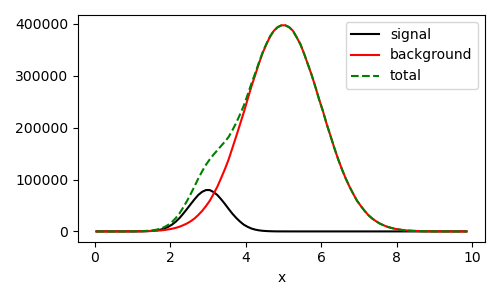

In [3]:
# numerial pdfs for signal and background
dx = 0.1
bin_edges = np.arange(xmin, xmax, dx)
bin_centr = (bin_edges[1:] + bin_edges[:-1])/2.

# signal
x = np.random.normal(loc=3, scale=0.5, size=mus*100000)
counts, _ = np.histogram(x, bins=bin_edges)
signal = (bin_centr, counts)

# background
x = np.random.normal(loc=5, scale=1, size=mub*100000)
counts, _ = np.histogram(x, bins=bin_edges)
background = (bin_centr, counts)

composed = (bin_centr, signal[-1] + background[-1])

plt.figure(figsize=[5, 3])
plt.plot(    *signal, label=    "signal", c="k")
plt.plot(*background, label="background", c="r")
plt.plot(  *composed, label=     "total", c="g", linestyle='dashed')

plt.xlabel("x")
plt.legend()
plt.tight_layout();

In [4]:
## SPACE
obs = zfit.Space('x', limits=(xmin, xmax))

## PDFs

# signal
signal_data = zfit.Data.from_numpy (obs=obs, array=signal[0], weights=signal[-1])
signal_pdf  = zfit.pdf.KDE1DimExact(obs=obs, data=signal_data, bandwidth="adaptive_zfit")

# background
backg_data  = zfit.Data.from_numpy (obs=obs, array=background[0], weights=background[-1])
backg_pdf   = zfit.pdf.KDE1DimExact(obs=obs, data=backg_data, bandwidth="adaptive_zfit")

# composed
N = 1e2
ns = zfit.Parameter("ns", 1, 0, N)
nb = zfit.Parameter("nb", 1, 0, N)

signal_pdf.set_yield(ns)
backg_pdf .set_yield(nb)

pdfs = [signal_pdf, backg_pdf]
model = zfit.pdf.SumPDF(pdfs=pdfs)

## MINIMIZER
minimizer = zfit.minimize.Minuit(gradient=True)

In [7]:
# generate experiment
mus, mub = 10, 20
with zfit.param.set_values([ns, nb], [mus, mub]):
    data = model.sample(n=np.random.poisson(mus + mub))

# LOSS
nll = zfit.loss.ExtendedUnbinnedNLL(model, data)
nll.create_new()

# FIT
result = minimizer.minimize(nll)

# ERRORS
errors, _ = result.errors(method='minuit_minos')

print("Valid", result.valid)
print(result.params)

Valid True
name      value               errors         minuit_minos    at limit
------  -------  -------------------  -------------------  ----------
ns       14.764  -    4.1   +    4.8  -    4.1   +    4.8       False
nb      28.2628  -    5.4   +    6.1  -    5.4   +    6.1       False


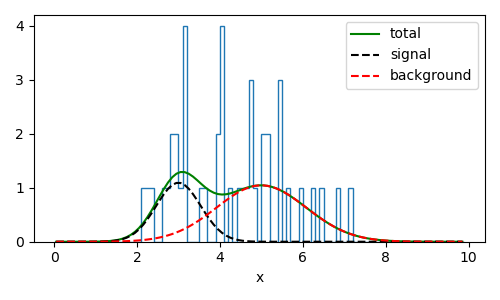

In [8]:
plt.figure(figsize=[5, 3])

bins = np.arange(*obs.limit1d, 0.1)
binc = (bins[1:] + bins[:-1])/2.

data = data.unstack_x().numpy()

plt.hist(data, bins=bins, histtype="step", density=False)

plt.plot(binc,      model.pdf(binc)*len(data)*np.diff(bins), label=     "total", c="g", linestyle="-")

plt.plot(binc, signal_pdf.pdf(binc)*result.params["ns"]["value"]*np.diff(bins)
        , label=    "signal", c="k", linestyle="--")
plt.plot(binc,  backg_pdf.pdf(binc)*result.params["nb"]["value"]*np.diff(bins)
        , label="background", c="r", linestyle="--")

plt.xlabel("x")
plt.legend()
plt.tight_layout();